# Please see here for a Notebook with the Maps working: 

http://nbviewer.jupyter.org/github/darioAnongba/EPFL-ADA/blob/master/Labs/03%20-%20Interactive%20Viz/Homework3.ipynb?flush_cache=true

# Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fl
import os, sys, json, branca
%load_ext autoreload
%autoreload 2

DATA_DIR = 'data/'

# Task 1
Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

## Solution
#### Explanation
By going on the 'eurostat' website, we've found an interesting file about unemployment, containing a list of europeans countries (not only in EU, so with Switzerland as well) and their unemployment rate, so we've decided to use this one as our basis for this task.

We've noted that not all countries contained in the TopoJson file were present in the file we downloaded from 'eurostat' (e.g Russia), so we've tried to find those in other files in 'eurostat' but we haven't found anything about those. So we've decided not to show them in any special color on the map, so that it shows that we don't have any information about those. Another thing that we had to be careful with was the country 'Great Britain'. Indeed, we're using the country codes to map the countries from the 'eurostat' file to the TopoJson one, but the country code of 'Great Britain' is 'GB' in the TopoJson, but 'UK' in the 'eurostat' file, so we had to replace 'UK' into 'GB' in the DataFrame created from the 'eurostat' file (we did the same for Greece). Then, we've also removed the rows corresponding to an invalid country code (not 2 characters).

We've decided to use the colors yellow, orange and red (from lower to higher unemployment rate) so that it intuitionally shows that the more "red-ish" the countries are, the "worst" they are (in terms of unemployement rate). Concerning the separation into multiple data classes, we decided to use a linear color scale to correctly show outliers (see further explanation below the map).

Then, we thought that it would be useful to add some interaction on the map (e.g. popup when clicking on a country). But we haven't found any way of doing that with the TopoJson files, so we've used 'http://jeffpaine.github.io/geojson-topojson/' to convert the TopoJson files into GeoJson (see 'geojson' folder). Using those files, we were able to add highlighting when hovering a country on the map and displaying a popup containing the name of the country with its unemployment rate when clicking on it.

We think the map is meaningful and intuitive with those information and those interactions.

#### Code

In [2]:
# Read and rename columns of unemployment data
unemployment = pd.read_csv('data/unemployment_data.csv')
unemployment = unemployment[['GEO', 'Value']]
unemployment = unemployment.rename(columns={'GEO': 'country', 'Value': 'unemp'})

# TopoJson
country_topo = os.path.join('topojson', 'europe.topojson.json')
ch_topo = os.path.join('topojson', 'ch-cantons.topojson.json')

# GeoJson
country_geo = os.path.join('geojson', 'europe.geojson.json')
ch_geo = os.path.join('geojson', 'ch-cantons.geojson.json')

In [3]:
# Manually change 'UK' and 'EL' to 'GB' and 'GR' because topojson/geojson using 'GB'
unemployment.loc[unemployment['country'] == 'UK', ['country']] = ['GB']
unemployment.loc[unemployment['country'] == 'EL', ['country']] = ['GR']

# Remove rows that are not countries (country code should be a string with length = 2)
unemployment = unemployment.loc[unemployment['country'].str.len() == 2]
unemployment.head()

,country,unemp
6,BE,7.8
7,BG,7.6
8,CZ,4.0
9,DK,6.2
10,DE,4.1


In [4]:
# Read country_topo file
country_geo_json = json.load(open(country_geo))
    
# Remove countries that are not in our data
new_features = []
for feature in country_geo_json['features']:
    country_id = feature['id']
    if (unemployment['country'] == country_id).any():
        new_features.append(feature)
        
country_geo_json['features'] = new_features

In [5]:
m = fl.Map(location=[46.57, 7.8], zoom_start=3, control_scale=False, prefer_canvas=False)

colorscale = branca.colormap.linear.YlOrRd.scale(unemployment.unemp.min(), unemployment.unemp.max())

def highlight_function(feature):
    return {
        'color': 'black',
        'weight': 3,
        'dashArray': '5, 2'
    }

def style_function(feature):
    unemp_rate = float(unemployment[unemployment['country'] == feature['id']].unemp)
    return {
        'fillOpacity': 0.7,
        'weight': 0.6,
        'color': 'black',
        'fillColor': colorscale(unemp_rate),
        'opacity': 1
    }

for feature in country_geo_json['features']:
    c = fl.GeoJson(
        feature,
        name=feature['properties']['NAME'],
        overlay=False,
        style_function=style_function,
        highlight_function=highlight_function
    )
    
    unemp_rate = float(unemployment[unemployment['country'] == feature['id']].unemp)
    fl.Popup('{}\nunemployment: {}%'.format(feature['properties']['NAME'], unemp_rate)).add_to(c)
    c.add_to(m)

m.add_child(colorscale)
m

As we can see, there are 2 big outliers which are Spain and Macedonia (more than 19% of unemployment). The other countries can be separated into 2 categories: unemployment rate between 3% and 7% (low unemployment rate) and unemployment rate between 7% and 13% (medium-high unemployment rate). We could have shown the countries in only 3 colors, but using a linear color scale (as we did) also works to show the different "types" of countries.

# Task 2

Go to the amstat website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

> HINT Go to the details tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through.
Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

## Solution

### Explanation and assumptions

#### Explanations

For this task. We used the data from the amstat website and chose our features to be "unemployed (without job and looking for one)", "searching for a job (both unemployed and employed)" and "searching for a job while being employed".

Given these features and the unemployment rate by canton. We were able to deduce the size of the active population per canton and to plot 2 separate maps.
* The first one represents the unemployment rate per canton where the unemployment rate is: `searching for a job` / `active population`
* The second one represents the unemployment rate per canton where the unemployment rate is: `searching for a job while being unemployed` / `active population`

This shows two similar maps with a few differences explained below.

In the process of cleaning the data, we had to transform the data into numeric types (for numeric columns) and also had to manually compute a mapping of the names between the topoJSON canton codes and the names in the fetched data

We decided to use the data for the month of September because it is the most recent dataset. **Caveat**: Using only the month of september can create a seasonal bias because in terms of unemployment, the rates vary depending on the season.

#### Assumptions

* While retrieving the data, we had the choice between "Unemployment for young people", "unemployment" and "looking for a job". For this task, we do not use the dataset "unemployment for young people" because it's a subset of the "unemployment" dataset so we do not need it

* We assume (and actually verified) that people that currently have a job and are looking for a new one are  taken into account in the unemployment rate

### Data loading

We load the unemployment data and process it

In [6]:
# Name of the columns
columns_names = ['region', 'canton', 'unemp_rate', 'unemp', 'searching', 'searching_employed']
# columns to keep
columns_keep = ['Région linguistique', 'Canton', 'Total', 'Total.1', 'Total.2', 'Total.3']

swiss_unemployment = pd.read_csv(
    DATA_DIR + 'swiss_unemp.txt',
    usecols=columns_keep,
    skiprows=[1]
)

# Renaming of the columns and aggregation by cantons
swiss_unemployment.columns = columns_names
swiss_unemployment.head()

,region,canton,unemp_rate,unemp,searching,searching_employed
0,Suisse alémanique,Zurich,3.3,27'225,34'156,6'931
1,Suisse alémanique,Berne,2.4,13'658,18'385,4'727
2,Suisse alémanique,Lucerne,1.7,3'885,6'756,2'871
3,Suisse alémanique,Uri,0.6,112,257,145
4,Suisse alémanique,Schwyz,1.7,1'455,2'229,774


It is possible here to see that the `searching` feature is the sum of the `unemp` and `searching_employed` metrics

In [7]:
# Mapping of the code names in the topoJSON file and the data
name_to_code = {'Zurich':'ZH', 
                'Berne':'BE',
                'Lucerne':'LU',
                'Uri':'UR',
                'Schwyz':'SZ',
                'Obwald':'OW',
                'Nidwald':'NW',
                'Glaris':'GL',
                'Zoug':'ZG',
                'Fribourg':'FR',
                'Soleure':'SO',
                'Bâle-Ville':'BS',
                'Bâle-Campagne':'BL',
                'Schaffhouse':'SH',
                'Appenzell Rhodes-Extérieures':'AR',
                'Appenzell Rhodes-Intérieures':'AI',
                'St-Gall':'SG',
                'Grisons':'GR',
                'Argovie':'AG',
                'Thurgovie':'TG',
                'Tessin':'TI',
                'Vaud':'VD',
                'Valais':'VS',
                'Neuchâtel':'NE',
                'Genève':'GE',
                'Jura':'JU'}

In [8]:
swiss_unemployment.canton = swiss_unemployment.canton.map(name_to_code)

We load the TopoJSON of swiss cantons 

In [9]:
canton_topo = json.load(open('topojson/ch-cantons.topojson.json'))

## Unemployment rate by cantons

In [10]:
m = fl.Map(location=[46.9,8.4], zoom_start=8)
m.choropleth(
    geo_data=canton_topo,
    topojson='objects.cantons',
    name='choropleth',
    data=swiss_unemployment,
    columns=['canton', 'unemp_rate'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name='Unemployment Rate (%)'
)


fl.LayerControl().add_to(m)

m

## Unemployment rates by cantons without people already employed

We transform the columns that are strings into integers (to do so we must delete the quotes)

In [11]:
def remove_quotes(df, column_name):
    return df[column_name].str.replace("'", '')

In [12]:
swiss_unemployment['unemp'] = remove_quotes(swiss_unemployment, 'unemp')
swiss_unemployment['searching'] = remove_quotes(swiss_unemployment, 'searching')
swiss_unemployment['searching_employed'] = remove_quotes(swiss_unemployment, 'searching_employed')
swiss_unemployment[['unemp', 'searching', 'searching_employed']] = swiss_unemployment[['unemp','searching', 'searching_employed']].apply(pd.to_numeric)

In [13]:
swiss_unemployment['active_pop'] = swiss_unemployment['searching'] / (swiss_unemployment['unemp_rate'] / 100)
swiss_unemployment['unemp_rate_not_employed'] = swiss_unemployment['unemp'] / swiss_unemployment['active_pop'] * 100

In [14]:
m = fl.Map(location=[46.9, 8.4], zoom_start=8)
m.choropleth(
    geo_data=canton_topo,
    topojson='objects.cantons',
    name='choropleth',
    data=swiss_unemployment,
    columns=['canton', 'unemp_rate_not_employed'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name='Unemployment Rate (%)'
)


fl.LayerControl().add_to(m)

m

Here we can see that some cantons fall into different categories than the previous map. It means that the same data can be interpreted in various ways depending of the initial assumptions.

For example, here we see that Ticino has a similar unemployment rate than Valais and Berne, whereas this was not true in the first map. Same for Aargau, Solothurn, etc

# Task 3

**a)** Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

## Solution

### Explanation and assumptions

**Explanation**

For this task, we use the dataset 2.1 Taux de chômage found on amstat.

We manualy created a dictionnary to convert Kanton names to abreviations. Then we split the data to create two dataframes, one for the swiss people and one for the foreign people. Finaly we use the average of the first 9 months of the year 2017 (Average computed by amstat) to show the unemployment rate for both swiss and foreign people. We plot them first as two choropleths side by side, then together as different layer on the same map. The colors are computed with the 1/6 quantiles of all data, foreign and swiss unemployment rate. This way we have the same color scale on both choropleths and we can compare them fairly.

To see better the difference between swiss and foreign unemployment rate we create a new dataframe where we aggregate by Kanton with the ratio of foreign unemployment over swiss unemployment. This way the ratio is not sensible to the overall rate of unemplyment in the Kanton.


#### Code

In [15]:
chom_all = pd.read_csv('data/swiss_unemployment_nation.csv',skiprows=[1])[['Canton','Nationalité','Total']]
chom_all.Canton = chom_all.Canton.map(name_to_code)
chom_all.Total = chom_all.Total.astype(float)
chom_aus = chom_all[chom_all['Nationalité']== 'Etrangers'].drop(['Nationalité'],axis=1)
chom_ch = chom_all[chom_all['Nationalité']== 'Suisses'].drop(['Nationalité'],axis=1)
q_rate = list(chom_all.Total.quantile(np.arange(0,1,1/5)).values)
q_rate.append(chom_all.Total.max())
q_rate[0]=0
treshold = []

# Read ch_geo file
ch_topo_json = json.load(open(ch_topo))
chom_all.head()

,Canton,Nationalité,Total
0,ZH,Etrangers,5.9
1,ZH,Suisses,2.7
2,BE,Etrangers,6.4
3,BE,Suisses,2.0
4,LU,Etrangers,4.5


In [16]:
m_aus = fl.Map(location=[ 46.8008, 8.2301 ], zoom_start=7)
def add_foreignLayer(m):
    m.choropleth(
        geo_data=ch_topo_json,
        topojson='objects.cantons',
        name='Foreigner',
        data=chom_aus,
        columns=['Canton', 'Total'],
        key_on='feature.id',
        threshold_scale=q_rate,
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.8,
    )
add_foreignLayer(m_aus)
m_aus.save('maps/m_aus.html')

In [17]:
m_ch = fl.Map(location=[ 46.8008, 8.2301 ], zoom_start=7)
def add_swissLayer(m):
    m.choropleth(
        geo_data=ch_topo_json,
        topojson='objects.cantons',
        name='Swiss',
        data=chom_ch,
        columns=['Canton', 'Total'],
        key_on='feature.id',
        threshold_scale=q_rate,
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.8,
    )
add_swissLayer(m_ch)
m_ch.save('maps/m_ch.html')

In [18]:
%%HTML
<div style="float:left">Foreigner unemployment</div>
<div style="float:right">Swiss unemployment</div><br>
<div>
    <iframe width="50%" height='350' src='maps/m_aus.html'/><iframe width="50%" height='350' src='maps/m_ch.html'/>
</div>

In [19]:
m_all = fl.Map(location=[ 46.8008, 8.2301 ], zoom_start=7)
add_foreignLayer(m_all)
add_swissLayer(m_all)
fl.LayerControl().add_to(m_all)
m_all.save('maps/m_all.html')

In [20]:
%%HTML
<iframe width="100%" height='350' src='maps/m_all.html'/>

In [21]:
chom_diff = chom_all.copy()
chom_diff = chom_diff[chom_diff['Nationalité'].isin(['Suisses','Etrangers'])]

def both_rate():
    factor = chom_diff['Nationalité'].map(lambda x: 1 if x=='Suisses' else 0)
    return chom_diff['Total']* factor, chom_diff['Total'] *(1-factor)

chom_diff['unemp_suisses'], chom_diff['unemp_etrangers'] = both_rate()
chom_diff = chom_diff.groupby('Canton').sum().drop(['Total'],axis=1).reset_index()
chom_diff['diff'] = chom_diff['unemp_etrangers'] / chom_diff['unemp_suisses']
m_diff = fl.Map(location=[ 46.8008, 8.2301 ], zoom_start=7)
m_diff.choropleth(
    geo_data=ch_topo_json,
    topojson='objects.cantons',
    name='Swiss',
    data=chom_diff,
    columns=['Canton', 'diff'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name='Ratio of Unemployment Rate'
)
m_diff.save('maps/m_diff.html')
chom_diff.sort_values('diff',ascending=False).head(10)

,Canton,unemp_suisses,unemp_etrangers,diff
21,UR,0.5,4.3,8.600000
1,AI,0.6,3.3,5.500000
13,NW,0.7,3.5,5.000000
9,GR,0.8,3.9,4.875000
14,OW,0.6,2.7,4.500000
11,LU,1.3,4.5,3.461538
18,SZ,1.2,3.9,3.250000
3,BE,2.0,6.4,3.200000
23,VS,2.3,7.3,3.173913
19,TG,1.5,4.5,3.000000


In [22]:
%%HTML
<iframe width="100%" height='350' src='maps/m_diff.html'/>

##### Results

We see here that in the canton of Uri  there is 8 times more unemployment for foreign people. Appenzell Innerrhoden and Nidwalden also have a high rate which is 5 times higher.

#### b)
Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data

## Solution

### Explanation and Assumptions

**Explanation**

For this part we use another dataset (1.1 Chômeurs et demandeurs d'emploi selon divers critères) which contains both information, nationality and age category. The disadvantage is that it is not the rate of unemployment but the number unemployed people.
We use statistics of september 2017. To compute the unemployment rate we will take the number of unemployed (Chômeurs inscrits) over the population.

**Assumptions**

* Since we miss the percentage of the population by age categoy and nationality we looked on internet on https://www.bfs.admin.ch/bfs/fr/home/statistiques/population.html. Those are statistics of the confederations for 2016.
* We assume that they changed only slightly so we will use them to compute the ratio of unemployment.
* We also assume that the rate of young and old people are the same for swiss and foreign people.
* Since the data is by age step of 5 years, we have to decide how to handle the category of age '60 ans et plus' (over 60). We will simply consider this age category as over 64 to match a percentage in the statistics we found.
* We don't use the information by canton because it will be an overdose of information and not much insights could be found.

In [23]:
# Constants
POPULATION = 8419600
SWISS = POPULATION * 75/100
FOREIGNER = POPULATION * 25/100
NINETEENERS = 20.1/100
THIRTYNINERS = 26.7/100
SIXTYFOURERS = 35.1/100
OVERSIXTYFOURERS = 18.1/100

# Return the percentage of population for a minimum age of a category
def switch(x):
    if(x < 20):
        return NINETEENERS
    elif(x < 40):
        return THIRTYNINERS / 4 #number of slice of 5 years
    elif(x < 60):
        return SIXTYFOURERS / 4 #number of slice of 5 years
    else:
        return OVERSIXTYFOURERS

# Compute the population slice for a given nationality and minimum age of a category
def populationSlice(nationality, minAge):
    pop = nationality.map(lambda x: SWISS if x == 'Suisses' else FOREIGNER)
    age = minAge.map(switch)
    return pop * age
    

# Load the data
chom_age = pd.read_csv('data/unemployment_nat_and_age.csv',skiprows=[1])[['Nationalité','Classes d\'âge par étapes de 5 ans', 'Septembre 2017']]
# Better columns name
chom_age.columns = ['Nationality','Age','Unemployment']
# Remove useless rows (like Total)
chom_age = chom_age.loc[chom_age['Nationality'].isin(['Suisses','Etrangers'])]
chom_age = chom_age.loc[chom_age['Age']!= 'Total']
# Extract minimum age for the category
chom_age['minAge'] =  chom_age.Age.apply(lambda x : int(x[:2]))
# Convert to Integer
chom_age.Unemployment = chom_age.Unemployment.map(lambda x : int(x.replace('\'','')))
# Compute populaiton slice
chom_age['Population slice'] = populationSlice(chom_age['Nationality'],chom_age['minAge'])
# Compute the rate
chom_age['Rate (%)'] = chom_age['Unemployment'] / chom_age['Population slice'] * 100
chom_age.head(10)

,Nationality,Age,Unemployment,minAge,Population slice,Rate (%)
0,Etrangers,15-19 ans,1648,15,423084.900,0.389520
1,Etrangers,20-24 ans,4187,20,140502.075,2.980027
2,Etrangers,25-29 ans,7276,25,140502.075,5.178571
3,Etrangers,30-34 ans,9692,30,140502.075,6.898119
4,Etrangers,35-39 ans,9311,35,140502.075,6.626948
5,Etrangers,40-44 ans,7883,40,184704.975,4.267887
6,Etrangers,45-49 ans,6565,45,184704.975,3.554317
7,Etrangers,50-54 ans,5617,50,184704.975,3.041066
8,Etrangers,55-59 ans,4212,55,184704.975,2.280393
9,Etrangers,60 ans et plus,2562,60,380986.900,0.672464


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

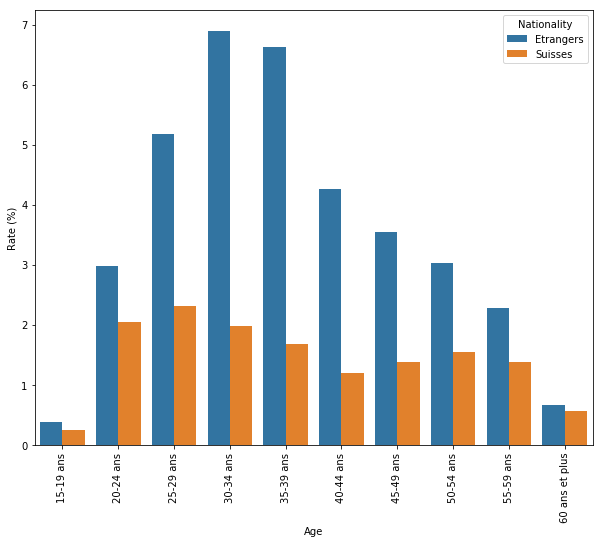

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Age',y='Rate (%)',hue='Nationality',data=chom_age,ax=ax)
plt.xticks(rotation='vertical')

##### Results

We can see that the rate of unemployment is very uneven for foreigners and swiss people. Only two categories have negligable difference : People under 20 years and people over 60 years old. This can be explained by the fact that people under 20 years old are mostly students and people over 60 years old may be retired.

# Task 4 (Bonus)

BONUS: using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

## Solution

#### Explanation

Using the data from task 2, it is possible to give a very precise unemployment rate for the 2 areas divided by the Röstigraben. We just need to group the data by linguistical region and plot the data

#### Code

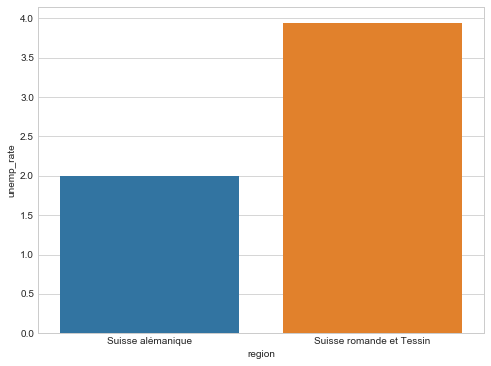

In [25]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

data = swiss_unemployment.groupby(by='region', as_index=False).mean()

# We need to drop one row representing the "total"
sns.barplot(ax=ax, x="region", y="unemp_rate", data=data.drop(2))

As we can see (and can predict from the maps), the swiss german part of Switzerland is doing way better than the other regions in terms of unemployment rates